# Importing the necessary library

In [11]:
import torch
import numpy as np
import pandas as pd
import ast
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# import mlflow.pyfunc
import mlflow.pytorch
import mlflow
from mlflow.tracking import MlflowClient

import nannyml as nml
import copy

import warnings
warnings.filterwarnings('ignore')

# Importing data file

In [12]:
df = pd.read_csv('data/cpu_data_custom_orangepi.csv')
# Convert string representation of lists back to actual lists
df['features'] = df['features'].apply(ast.literal_eval)
df.reset_index(drop=True, inplace=True)

In [13]:
df.tail()

,features,target
102114,"[69.2, 63.7, 54.9, 51.0, 100.0, 100.0, 100.0, ...",80.2
102115,"[64.4, 66.0, 58.8, 61.5, 100.0, 100.0, 100.0, ...",81.1
102116,"[71.6, 58.8, 57.4, 56.4, 98.0, 100.0, 100.0, 1...",79.3
102117,"[84.3, 66.3, 57.0, 37.1, 100.0, 100.0, 100.0, ...",82.1
102118,"[71.2, 62.4, 55.4, 54.9, 100.0, 99.0, 100.0, 1...",78.9


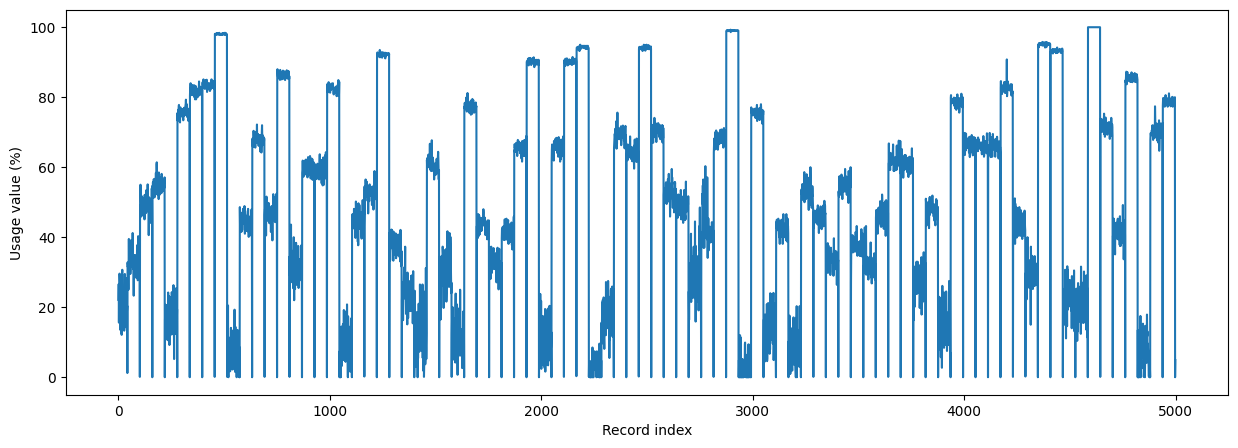

In [14]:
plt.figure(figsize=(15,5))
plt.plot(df[:5000].index, df['target'][:5000])
plt.xlabel('Record index')
plt.ylabel('Usage value (%)')
# plt.title('CPU Usage (%)')
plt.show()

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        lstm_out, _ = self.lstm(input.view(len(input), 1, -1))
        output = self.fc(lstm_out.view(len(input), -1))
        return output[-1]

In [16]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        x = torch.tensor(sample['features'], dtype=torch.float32)
        y = torch.tensor(sample['target'], dtype=torch.float32)
        return x, y

In [17]:
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    # print(f'Last Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')
    print('======== Model Training completed ========')

In [18]:
def finetune_model(model, dataloader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()  # Set the model to training mode
        
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
    # print(f'Last Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')
    print('======== Model Fine-tuning  completed ========')

In [19]:
input_size = 8  # Input size is the length of the input list
hidden_size = 16
output_size = 1
learning_rate = 0.001
epochs = 10

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
train_data = df[0:60000]
finetune_data = df[60000:70000]
test_data = df[70000:75000] # this data will be used for initial DLE training
prod_data = df [75000:]

X_test=test_data[['features']]
y_test=test_data['target']

In [21]:
train_dataset = CustomDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
train_model(model, train_dataloader, criterion, optimizer, epochs)

# Pushing pretrained model to the model registry

In [ ]:
mlflow.set_tracking_uri('http://localhost:5000')

In [ ]:
mlflow.set_experiment('Chapter-12')
def log_models(model,modelname):
    with mlflow.start_run() as run:
        mlflow.pytorch.log_model(model, modelname)
        # Register the model
        model_uri = f"runs:/{run.info.run_id}/{modelname}"
        mlflow.register_model(model_uri, "Ch12Models")
log_models(model,"ch12_model")

# Finetune and store updated model

In [ ]:
finetune_dataset = CustomDataset(finetune_data)
finetune_dataloader = DataLoader(finetune_dataset, batch_size=1, shuffle=False)
finetune_model(model, finetune_dataloader, criterion, optimizer, epochs)

In [ ]:
log_models(model,"ch12_model")

In [ ]:
def predict_model(dataloader, modelobj):
    test_running_loss = 0.0
    test_total_samples = 0
    test_absolute_errors = 0.0
    predicted_values = []
    actual_values=[]
    
    # Switch model to evaluation mode
    modelobj.eval()
    
    with torch.no_grad():  # No need to compute gradients during testing
        for data in dataloader:
            inputs, labels = data
            
            # Forward pass
            outputs = modelobj(inputs)
            predicted_values.append(outputs)
            actual_values.append(labels)
    
            # Calculate loss (MSE or MAE)
            test_loss = criterion(outputs, labels)
            test_running_loss += test_loss.item()
            
            # Calculate absolute error (MAE)
            test_absolute_error = torch.abs(outputs - labels)
            test_absolute_errors += test_absolute_error.sum().item()
            
            # Update total samples
            test_total_samples += labels.size(0)
    
    # Calculate Mean Absolute Error (MAE) on test dataset
    test_mean_absolute_error = test_absolute_errors / test_total_samples
    
    # Print loss and MAE on test dataset
    # print(f'Test Loss: {test_running_loss/len(test_dataloader)}, Test MAE: {test_mean_absolute_error}')
    
    predicted_list = [round(output.item(),3) for output in predicted_values]
    actual_list = [round(output.item(),3) for output in actual_values]
    
    return np.array(actual_list), np.array(predicted_list)

# Preparing testing data and train DLE

In [ ]:
test_dataset = CustomDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
y_true_test, y_pred_test=predict_model(test_dataloader, model)

In [ ]:
reference_df = test_data[['features']].copy()
reference_df['y_pred'] = y_pred_test 
reference_df['y_true'] = y_true_test 

# Creating features from the list
values = reference_df['features'].iloc[0]
for i, value in enumerate(values[::1], start=1):
    reference_df[f'lag_{9-i}'] = value
reference_df.drop(columns=['features'], inplace=True)

In [ ]:
def train_dle(reference_df):
    features=['lag_8', 'lag_7', 'lag_6','lag_5','lag_4', 'lag_3', 'lag_2', 'lag_1']
    dle = nml.DLE(
        metrics=['mse'],
        y_true='y_true',
        y_pred='y_pred',
        feature_column_names=features, chunk_size=150)
    dle.fit(reference_df) # fit on the reference dataset
    return dle

In [ ]:
dle=train_dle(reference_df)

# Model Monitoring in Production

In [ ]:
data_flow=prod_data.reset_index(drop=True)

# Number of records in each batch
batch_size = 1000

# Calculate the total number of batches needed
total_batches = int(np.ceil(len(data_flow) / batch_size))

# Create the batch numbers
batch_numbers = np.repeat(range(1, total_batches + 1), batch_size)[:len(data_flow)]

# Add the batch numbers as a new column
data_flow['batch_number'] = batch_numbers

In [ ]:
def load_latest_model():
    # Initialize the MLflow client
    client = MlflowClient()
    model_name = "Ch12Models"
    
    # Get all versions of the model
    all_versions = client.get_registered_model(name=model_name).latest_versions

    # Find the latest version based on last updated timestamp
    latest_version = max(all_versions, key=lambda version: version.last_updated_timestamp)

    # Construct the model URI
    model_uri = f"models:/{model_name}/{latest_version.version}"

    # Load the model
    model = mlflow.pytorch.load_model(model_uri)
    # print(f"Loaded model version: {latest_version.version}")

    return model

In [ ]:
# Predicting new batch
def predict_batch(batch_data, modelobj):
    predicted_values = []
    
    features_list=batch_data['features'].tolist()
    tensors = [torch.tensor([feature]) for feature in features_list]

    modelobj.eval()
    with torch.no_grad():
        for inputs in tensors:
            outputs = modelobj(inputs)
            predicted_values.append(outputs)
    predicted_list = [output.item() for output in predicted_values]
    # predicted_list = [round(output.item(),3) for output in predicted_values]
    
    features_values = batch_data['features'].iloc[0]
    for i, value in enumerate(features_values[::1], start=1):
        batch_data[f'lag_{9-i}'] = value
    # batch_data.drop(columns=['features'], inplace=True)
    batch_data['y_pred']=predicted_list
    
    return batch_data

In [ ]:
# all_models = mlflow.search_runs(experiment_names=["Chapter-12"])

# for run_id in all_models["run_id"]:
#     model_uri = f"runs:/{run_id}/finetuned_model"
#     print(model_uri)

In [ ]:
def comparing_model(batch_data, latest_model_mae):
    features_list=batch_data['features'].tolist()
    tensors = [torch.tensor([feature]) for feature in features_list]
    
    # Retrieve all models from the model registry
    all_models = mlflow.search_runs(experiment_names=["Chapter-12"])
    
    mae_dict = {}
    for run_id in all_models["run_id"]:
        predicted_values = []
        model_uri = f"runs:/{run_id}/ch12_model"
        model = mlflow.pytorch.load_model(model_uri)
        model.eval()
        with torch.no_grad():
            for inputs in tensors:
                outputs = model(inputs)
                predicted_values.append(outputs)
        predicted_list = [output.item() for output in predicted_values]
        
        mae = mean_absolute_error(batch_data['target'], predicted_list)
        mae_dict[model_uri] = mae

    # Select the best performing model
    best_model_uri = min(mae_dict, key=mae_dict.get)

    # Benchmark the model on the current batch of data if its performance is lower than that of the best model retrieved from the model registry.
    if mae_dict[best_model_uri]<latest_model_mae:
        best_model = mlflow.pytorch.load_model(best_model_uri)
        batch_dataset = CustomDataset(batch_data)
        batch_dataloader = DataLoader(batch_dataset, batch_size=1, shuffle=False)
        finetune_model(best_model, batch_dataloader, criterion, optimizer, epochs)
        log_models(best_model,"ch12_model")  

In [ ]:
# latest_model=load_latest_model()
# for m in range(1,2):
#     p=data_flow.query('batch_number==@m')
#     # analysis_df=predict_batch(p.copy(), latest_model)
#     comparing_model(p.copy())

In [ ]:
# Step-by-step process

In [ ]:
# temp=0 # 
flag=False #jsut for tracking 
predicted_df=pd.DataFrame()
benchmark_df=pd.DataFrame()

latest_model=load_latest_model() # calling current model
for batch_number in range(1, total_batches+1):
    data=data_flow.query('batch_number==@batch_number')
    analysis_df=predict_batch(copy.deepcopy(data), latest_model) # Need to explain as it is very important
    predicted_df=predicted_df.append(analysis_df,ignore_index=True) # Just to store all inputs, batches and predicted results 

    #### need to update dle on previous batches because for current data GT is not available
    
    estimated_performance = dle.estimate(copy.deepcopy(analysis_df)) # estimate on the current batch of data
    drift=estimated_performance.to_df()['mse']['alert']
    
    
    # Benchmark the model on the current batch of data if its performance is lower than that of the best model retrieved from the model registry
    # if(temp>batch_number):
    if(flag==True):
        latest_model_mae = mean_absolute_error(benchmark_df['target'], benchmark_df['y_pred'])
        comparing_model(copy.deepcopy(benchmark_df), latest_model_mae)
        flag=False
                       
    
    # Action if Drift is detected in current batch
    # remove do from do_benchmark
    if drift.any():
        benchmark_df=copy.deepcopy(analysis_df)
        flag=True
        # temp=batch_number+2
    predicted_df['y_true']=predicted_df['target']
    dle=train_dle(predicted_df.tail(batch_size*5)) 